In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf                

2024-05-15 18:40:36.989116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 18:40:36.989283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 18:40:37.153384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# This size needed for EfficientNetB0
IMAGE_SIZE = (224, 224)

def load_data():
    datasets = ['/kaggle/input/face-expression-recognition-dataset/images/train/']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
#                 image = cv2.imread(img_path)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking 1k images from of each type
                # bcause Notebook getting out of memory error
                count = count + 1
                if count == 1000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

(images, labels) = load_data()[0]

Loading /kaggle/input/face-expression-recognition-dataset/images/train/


 14%|█▍        | 999/7164 [00:05<00:34, 180.56it/s]


In [3]:
# # Memory taken by array
print((images.nbytes/1024)/1024)

permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1)
train_images = train_images / 255.0 
test_images = test_images / 255.0

# # Memory taken by array
# (images.nbytes/1024)/1024

3695.671875


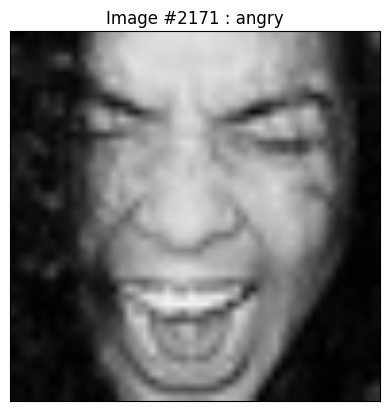

In [4]:
def display_random_image(class_names, images, labels):   
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

# base_model = EfficientNetB0(
#     weights='imagenet', 
#     input_shape=(224, 224, 3),
#     include_top=False
#     ) 

# base_model = VGG16(
#     weights='imagenet', 
#     input_shape=(224, 224, 3),
#     include_top=False
#     ) 

# base_model.trainable = False

In [6]:
# inputs = Input(shape=(224, 224, 3))
# model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# # Freeze the pretrained weights
# model.trainable = False

# # Rebuild top
# x = GlobalAveragePooling2D(name="avg_pool")(model.output)
# x = BatchNormalization()(x)

# x = Dropout(0.2)(x)
# outputs = Dense(7, activation="softmax")(x)

# # Create the final model
# model = Model(inputs, outputs)

# model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

inputs = Input(shape=(224, 224, 3))
base_model = VGG16(
    weights='imagenet', 
    input_tensor=inputs,
    include_top=False
    ) 

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(50, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(show_trainable=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 7)             │      3,591 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,720,327 (56.15 MB)

 Trainable params: 4,615 (18.03 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [7]:
history = model.fit(train_images, train_labels, epochs=10, validation_split = 0.2)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1812s 13s/step - accuracy: 0.2578 - loss: 1.9182 - val_accuracy: 0.1907 - val_loss: 1.8558
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1781s 12s/step - accuracy: 0.3466 - loss: 1.6791 - val_accuracy: 0.3313 - val_loss: 1.7364
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1773s 12s/step - accuracy: 0.4042 - loss: 1.5728 - val_accuracy: 0.3762 - val_loss: 1.6269
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1726s 12s/step - accuracy: 0.4070 - loss: 1.5410 - val_accuracy: 0.3814 - val_loss: 1.5624
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1696s 12s/step - accuracy: 0.4224 - loss: 1.5142 - val_accuracy: 0.4055 - val_loss: 1.5357
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1691s 12s/step - accuracy: 0.4360 - loss: 1.4796 - val_accuracy: 0.4055 - val_loss: 1.5237
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1705s 12s/step - accuracy: 0.4557 - loss: 1.4373 - val_accuracy: 0.4133 - val_loss: 1.5165
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 1707s 12s/step - accuracy: 0.4642 - loss: 1

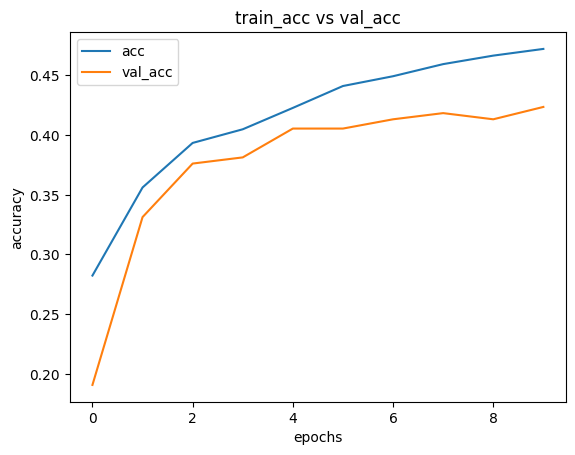

In [8]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

In [9]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history = model.fit(train_images, train_labels, epochs=1, validation_split = 0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 7)             │      3,591 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,729,559 (56.19 MB)

 Trainable params: 14,719,303 (56.15 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 9,232 (36.07 KB)

Fitting the end-to-end model
145/145 ━━━━━━━━━━━━━━━━━━━━ 5174s 36s/step - accuracy: 0.4891 - loss: 1.3474 - val_accuracy: 0.4487 - val_loss: 1.4617


21/21 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step


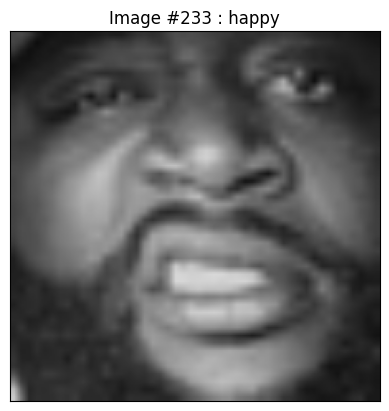

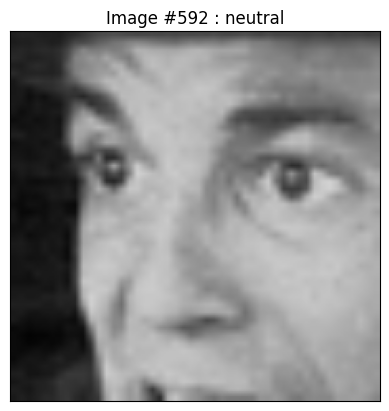

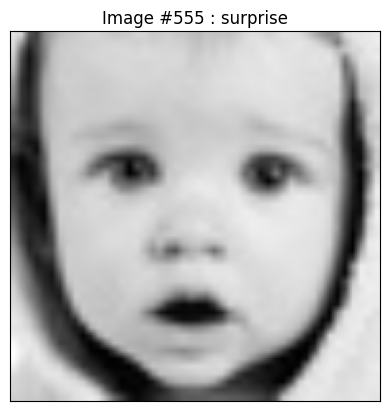

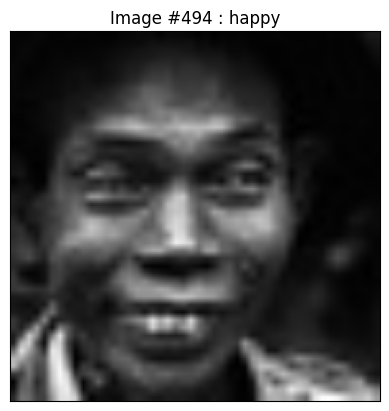

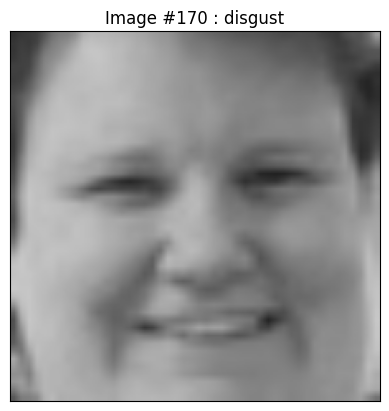

In [10]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

# Display Random Five predicted labels
for i in range(5):
    display_random_image(class_names, test_images, pred_labels) 

In [11]:
# def unfreeze_model(model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, BatchNormalization):
#             layer.trainable = True

#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
#     model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


# unfreeze_model(model)
# print(model.summary())

<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        IF YOU LIKED THE NOTEBOOK PLEASE DO UPVOTE!  
    </h2>
    </div>